# Project

In [1]:
import pandas as pd
import json as JSON
import numpy as np

from collections import Counter
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

from pyspark.ml.fpm import PrefixSpan
from pyspark.shell import sc
from pyspark.sql.functions import desc
from pyspark.sql.types import Row


Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.3.0
      /_/

Using Python version 3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022 16:36:42)
Spark context Web UI available at http://10.0.13.166:4040
Spark context available as 'sc' (master = local[*], app id = local-1665946205717).
SparkSession available as 'spark'.


In [2]:
df = pd.read_csv('keystrokes-recipes.csv')
KEYWORDS = ['Shift', 'Backspace', 'Enter', 'ArrowDown',
            'ArrowLeft', 'ArrowRight', 'ArrowUp', 'End', 'Control', 'CapsLock']

#create a copy of the dataset to another csv file

df.to_csv('keystrokes-recipes-modified.csv', index=False)

- ```keystrokes-recipes.csv``` is the original data and we keep it in case we want to look back at one moment
- ```keystrokes-recipes-modified.csv``` is the modified data


## Data cleaning and sorting


Our data consists of a csv file with event dates, user ids, keystrokes and the recipes they wrote.
We clean all the data by working throught the keystrokes first.

* We group the characters into the word written and separate between important keywords typed such as backspace, shift, enter etc. The sequence ['shift', 'p', 'e', 'r'] becomes ['shift', 'per'] 
* We sort by user id to get a better idea of every recipe every student has written.

## Processing the data


The first thing we did was isolate the keystrokes to a new ```json``` file saved in ```data/all_keystrokes.json```

The next step is to group words together and separate them from keywords and we work between each whitespace.
 
So for example this entry: 

```{'time': 1662252404346, 'character': 'Shift'}, {'time': 1662252404376, 'character': 'f'}, {'time': 1662252404505, 'character': 'i'}``` 

gives the following output: 

```{'time': 1662252404346, 'word': 'Shift'}, {'time': 1662252404505, 'word': 'fi'}```


In [3]:
def find_seq(chars):
    return "".join(list(filter(lambda _ : _ not in KEYWORDS, chars)))

def separate_entry(json_values):
    new_data = []
    last_whitespace = 0
    characters = [arr[1] for arr in json_values]

    for i, (time, character) in enumerate(json_values):
        if character.isspace():
            word = characters[last_whitespace: i]
            if not any(i in word for i in KEYWORDS):
                new_data.append({'time': time, 'word': "".join(word)})
            else:
                new_data.append({'time': time, 'word': find_seq(word)})
            last_whitespace = i+1

        elif character in KEYWORDS:
            new_data.append({'time': time, 'word': character})
        
        elif not character:
            continue

    return new_data

def compute():
    new_df = pd.DataFrame(pd.read_json("data/all_keystrokes.json"))
    arr = []
    for jsonf in new_df.values:
        sub_arr = []
        for d in jsonf:
            if d is not None:
                sub_arr.append([d["time"], d["character"]])
        arr.append(sub_arr)

    result = []
    for jsonf in arr:
        result.append(separate_entry(jsonf))

    with open("data/new_data.json", "w") as f:
        JSON.dump(result, f)
    return

compute()



Basically, ``` compute()``` will format the data for the ```separate_entry``` function and when everything is computed, it dumps all the data in a new json file.

```separate_entry``` computes the words between each space character, all the while separating words from keywords. It uses the function ```find_seq``` to separate the characters from keywords so it allows to isolate words between each whitespaces.


## Modifying the CSV file

We just modify the keystroke data for each row of the original data in ```keystrokes-recipes.csv``` but apply it to ```keystrokes-recipes-modified.csv```

In [4]:
jsons = pd.read_json('data/new_data.json').values.tolist()

for i, json in enumerate(jsons):
    jsons[i]= list(filter(lambda _ : _ is not None, json))

def write_to_csv_file(filename, recipes_len):
    df = pd.read_csv(filename)
    for i in range(recipes_len):
        df.loc[i,'ks'] = jsons[i]
    df.to_csv(filename, index=False)

write_to_csv_file('keystrokes-recipes-modified.csv', len(jsons))


## Sorting by user id

We want to sort by user id in order to differentiate behaviour between different people more easily

In [5]:
csv_filename = 'keystrokes-recipes-modified.csv'
pd.read_csv(csv_filename).sort_values(by='user_id', ascending=True).to_csv(csv_filename, index=False)

## Identifying patterns between different student recipes

Count the most common words used in the recipes and removing stopwords (they're noisy)

<AxesSubplot:xlabel='words'>

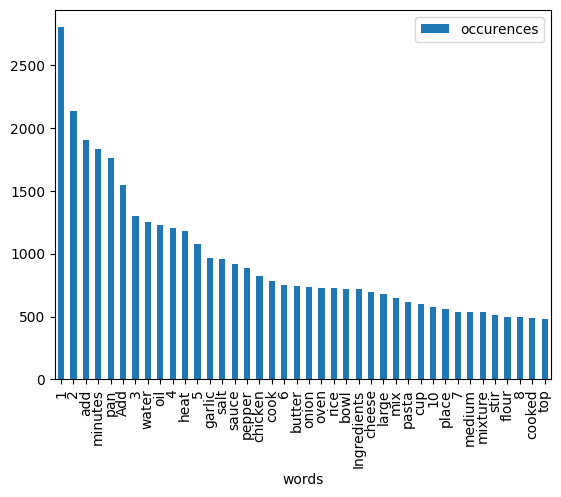

In [35]:
data = pd.read_csv(csv_filename)['recipe'].values
stop_words = set(stopwords.words('english'))
recipes_copy = list(map(lambda _ : word_tokenize(_), data.copy()))
recipes_without_stopwords = []
for recipe in recipes_copy:
    recipes_without_stopwords.append([w for w in recipe if not w.lower() in stop_words])    

flat_list = [item for sublist in recipes_without_stopwords for item in sublist]
flat_list = list(filter(lambda char : char not in [',', '.', '-', ':', '(', ')'], flat_list))
c = Counter(flat_list)

dframe = pd.DataFrame(c.most_common(40))
dframe.columns = ['words', 'occurences']

dframe.plot(kind='bar', x='words', y='occurences', linewidth=1)

Most of the recipes contain an order in which to proceed - ie 1) --- 2) --- 
Also interesting to see most of the common words are not ingredients

### Pattern mining

There are a total of 1091 recipes from 187 students. What we would like to do is either apply pattern mining for each student and their recipes to better understand each users writing. Or, we pick one recipe from each student and extract the underlying patterns each student share.

Given our data, we want to extract the longest common patterns as the shorter ones will only consist of heavily used words such as 'the', 'and'. Hence, given the running time of running the ```PrefixSpan``` algorithm using ```pyspark``` to find the patterns with ```maxPatternLength=10``` is over 10 minutes for only 5 recipes with a little ```minimum_support```, it would take approximately 1870 minutes (1091 recipes and 187 students gives roughly 5 recipes per student) to compute patterns for each student recipes. So, we ought to only pick one from each student and apply the ```PrefixSpan``` algorithm. Regardless - applying prefix span on the written recipes results in unsatisfying output.

To reduce the amount of computation of the algorithm, we simply pick the first recipe each student writes

   sequence  freq
0     [[.]]  1025
1  [[., .]]   997
2     [[,]]   987


<AxesSubplot:ylabel='sequence'>

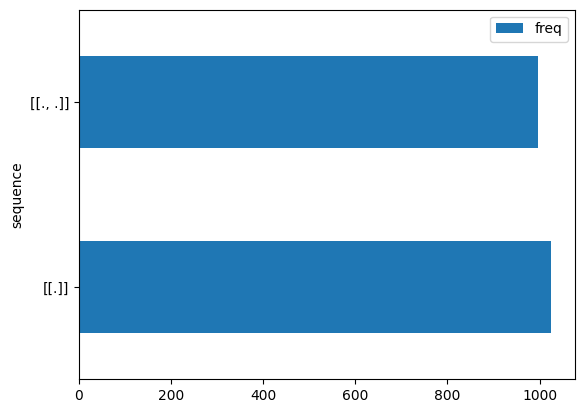

In [47]:
sorted_df = pd.read_csv(csv_filename)
first_recipe_each_student = sorted_df.groupby('user_id').head(1)
one_recipe_per_student = []
for index in first_recipe_each_student.index:
    one_recipe_per_student.append(word_tokenize((sorted_df.loc[index]['recipe'])))

df2 = pd.DataFrame([{'sequence': [['.']], 'freq': 1025}, {'sequence': [['.', '.']], 'freq': 997}, {'sequence': [[',']], 'freq': 987}])
print(df2)
df2.plot(kind='barh',x='sequence', y='freq')


From, there we can try to apply the PS algorithm

Parameters of ```PrefixSpan``` : 
* Minimum Support (```minSupport```) : support is calculated as the % of sequences containing the subsequence
* Maximum Subsequence Length (```maxPatternLength```) : speaks for itself

If ```minSupport``` is little and ```maxPatternLength``` is large, the running time of ```PrefixSpan``` gets exceedingly long. The contrary gives reasonable running time but some subsequences can be left undiscovered.


193
[Row(sequence=[['1']], freq=949), Row(sequence=[['2']], freq=937), Row(sequence=[['1', '2']], freq=901), Row(sequence=[['3']], freq=875), Row(sequence=[['1', '3']], freq=840), Row(sequence=[['2', '3']], freq=837), Row(sequence=[['4']], freq=832), Row(sequence=[['1', '2', '3']], freq=822), Row(sequence=[['1', '4']], freq=809), Row(sequence=[['2', '4']], freq=806), Row(sequence=[['5']], freq=804), Row(sequence=[['1', '2', '4']], freq=797), Row(sequence=[['3', '4']], freq=795), Row(sequence=[['1', '3', '4']], freq=787), Row(sequence=[['2', '3', '4']], freq=783), Row(sequence=[['1', '2', '3', '4']], freq=778), Row(sequence=[['1', '5']], freq=773), Row(sequence=[['minutes']], freq=768), Row(sequence=[['2', '5']], freq=764), Row(sequence=[['1', '2', '5']], freq=752), Row(sequence=[['add']], freq=750), Row(sequence=[['3', '5']], freq=748), Row(sequence=[['1', '3', '5']], freq=739), Row(sequence=[['4', '5']], freq=732), Row(sequence=[['2', '3', '5']], freq=731), Row(sequence=[['1', '2', '3

<AxesSubplot:ylabel='sequence'>

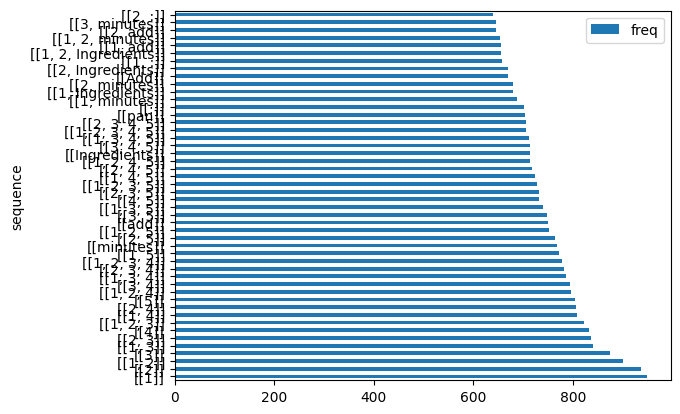

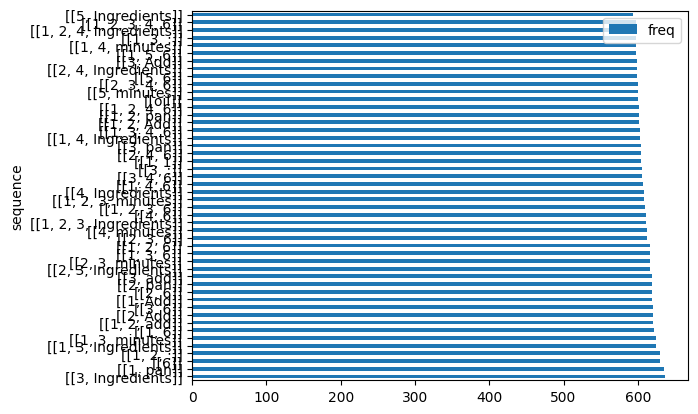

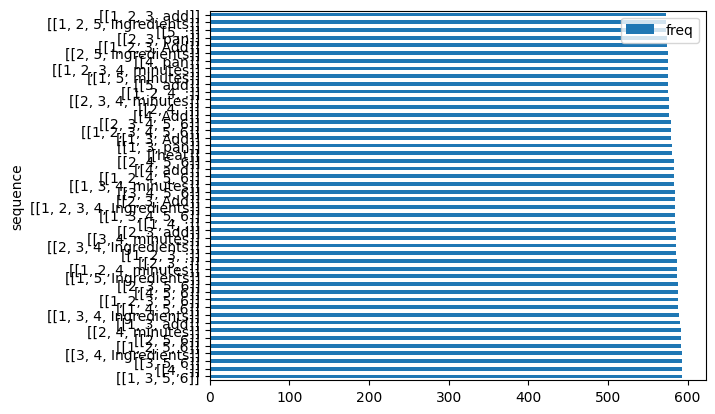

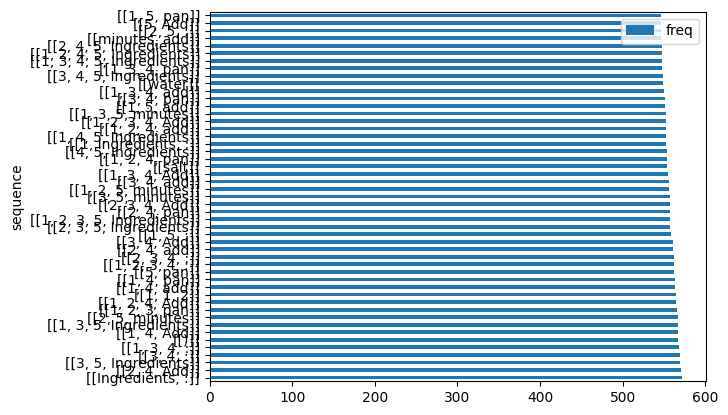

In [49]:
copy = recipes_without_stopwords.copy()

for i, tokenized in enumerate(copy):
    copy[i] = list(filter(lambda char: char != ',' and char != "." ,tokenized))

range_ = range(len(copy))
for i in range_:
    copy[i] = Row(sequence=[copy[i]])

l = [copy[i] for i in range_]
DF = sc.parallelize(l).toDF()

prefixSpan = PrefixSpan(minSupport=0.5, maxPatternLength=8, maxLocalProjDBSize=32000000)

# Find frequent sequential patterns.
a = prefixSpan.findFrequentSequentialPatterns(DF).sort(desc('freq')).collect()


midpoint = int(len(a)/2)
print(len(a))
print(a[:midpoint])

fourth = int(midpoint/2)
df2 = pd.DataFrame(list(map(lambda _: _.asDict(),a)))
df2[:midpoint].plot(kind='barh',x='sequence', y='freq')
df2[midpoint:].plot(kind='barh',x='sequence', y='freq')
df2[midpoint: 3*fourth].plot(kind='barh',x='sequence', y='freq')
df2[3*fourth:].plot(kind='barh',x='sequence', y='freq')




Can't really make anything of this which makes sense bc it looks for sequential patterns - not the general idea. For now this just confirms what the frequency word counter showed - that people make a list in their recipes but it's not that interesting.

* What we can do now is try to map each typed character as an insert action, count each backspace as a delete action and from those sequences, generate some patterns under the form (insert - insert - delete - insert ...)

* We can also try to check if any of the commands typed are of the form ```CTRL + C``` - ```CTRL + V``` to see if any of the students might have cheated

* divide the whole writing session in three parts (beginning, middle, end) for each recipe and study different parameters --- such as the number of keystrokes typed at each subsession, the number of inserts or deletions at each subsession and try to see what is the general trend --- without any results i'd personally say more inserts in the beginning and more deletions in the end with slower typing speeds in the middle

### pending approval from thiemo 

I Think of the 3 ideas the one with the insertions and deletions is the most interesting and easy to implement. The idea comes from a paper : Analysis of Keystroke Sequences in Writing Logs


## Comparing text insertions with deletions

First what we want to do is count the number of deletions (ie Backspaces) for each student

we will create a tuple for each student of the form ```(total insertions, total deletions)```

plot a scatter plot for each student and see if there are correlations

In [9]:
sdf = sorted_df

a = pd.read_json('data/new_data.json').values
sorted_indices = pd.read_csv(csv_filename).groupby('user_id')['user_id']



